<a href="https://colab.research.google.com/github/Al-Tayeb96/Cirrhosis-Prediction-Project-4---Part-1-Core-/blob/main/Project_4_Part_3_(Core).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras import metrics
from tensorflow.keras.layers import Dense, Dropout

from sklearn.metrics import classification_report, ConfusionMatrixDisplay



# Sci-kit learn
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

# Set pandas as the default output for sklearn
from sklearn import set_config
set_config(transform_output='pandas')

In [ ]:
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):

    # Get the classification report
    report = classification_report(y_true, y_pred)
    ## Print header and report
    header = "-"*70
    print(header, f" Classification Metrics: {label}", header, sep='\n')
    print(report)

    ## CONFUSION MATRICES SUBPLOTS
    fig, axes = plt.subplots(ncols=2, figsize=figsize)

    # create a confusion matrix  of raw counts
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', values_format="d", colorbar=colorbar,
                ax = axes[0],);
    axes[0].set_title("Raw Counts")

    # create a confusion matrix with the test data
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, values_format=".2f", colorbar=colorbar,
                ax = axes[1]);
    axes[1].set_title("Normalized Confusion Matrix")

    # Adjust layout and show figure
    fig.tight_layout()
    plt.show()

    # Return dictionary of classification_report
    if output_dict==True:
        report_dict = classification_report(y_true, y_pred, output_dict=True)
        return report_dict

In [ ]:
# Custom function for plotting each metric
def plot_history(history, figsize=(6,12), marker='o'):

    # Get list of metrics from history
    metrics = [c for c in history.history if not c.startswith('val_')]

    ## Separate row for each metric
    fig, axes = plt.subplots(nrows=len(metrics),figsize=figsize)

    # For each metric
    for i, metric_name in enumerate(metrics):

        # Get the axis for the current metric
        ax = axes[i]

        # Get metric from history.history
        metric_values = history.history[metric_name]
        # Get epochs from history
        epochs = history.epoch

        # Plot the training metric
        ax.plot(epochs, metric_values, label=metric_name, marker=marker)

        ## Check if val_{metric} exists. if so, plot:
        val_metric_name = f"val_{metric_name}"
        if val_metric_name in history.history:
            # Get validation values and plot
            metric_values = history.history[val_metric_name]
            ax.plot(epochs,metric_values,label=val_metric_name, marker=marker)

        # Final subplot adjustments
        ax.legend()
        ax.set_title(metric_name)
    fig.tight_layout()

    return fig, axes



In [ ]:
# Load Data
df = pd.read_csv('/content/drive/MyDrive/ CodingDojo/Intermediate ML/cirrhosis.csv',index_col='ID')
df.head()

,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
ID,,,,,,,,,,,,,,,,,,,
1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [ ]:
# Define target
target_col = "Status"


# Define X and y
y = df[target_col].replace({'D':0,'C':1,'CL':2}).copy()
X = df.drop(columns=[target_col]).copy()

X_train, X_val, y_train, y_val = train_test_split(X, y,test_size = 0.2,random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, random_state = 42)

In [ ]:
# Categorical Preprocessing Pipeline
# Save list of column names
ohe_cols = X_train.select_dtypes('object').columns
# Instantiate the individual preprocessors
impute_na = SimpleImputer(strategy='constant', fill_value = "NA")
# Instantiate the individual preprocessors
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
# Make pipeline with imputer and encoder
ohe_pipe = make_pipeline( impute_na,ohe_encoder)
# Making a ohe_tuple for ColumnTransformer
ohe_tuple = ('categorical',ohe_pipe, ohe_cols)
#________________________________________________________________________
# Numerical Prepprocessing Pipeline
# Save list of column names
num_cols = X_train.select_dtypes("number").columns
impute_na = SimpleImputer(strategy='constant', fill_value = 0)
# instantiate preprocessors
scaler = StandardScaler()
# Make a numeric preprocessing pipeline
num_pipe = make_pipeline( impute_na,scaler)
# Making a numeric tuple for ColumnTransformer
num_tuple = ('numeric', num_pipe, num_cols)

#_________________________________________________________________


In [ ]:
# Create the Column Transformer
prepprocessing=ColumnTransformer([num_tuple,ohe_tuple],verbose_feature_names_out=True)
prepprocessing

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [ ]:
prepprocessing.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value=0,
                                                                strategy='constant')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper',
       'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin',
       'Stage'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema'], dtype='object'))])

In [ ]:
# Transform the training data
X_train_processed = prepprocessing.transform(X_train)
# Transform the valditon data
X_val_processed=prepprocessing.transform(X_val)
# Transform the testing data
X_test_processed = prepprocessing.transform(X_test)
# View the processed training data
X_train_processed.head()



,numeric__N_Days,numeric__Age,numeric__Bilirubin,numeric__Cholesterol,numeric__Albumin,numeric__Copper,numeric__Alk_Phos,numeric__SGOT,numeric__Tryglicerides,numeric__Platelets,...,categorical__Ascites_Y,categorical__Hepatomegaly_N,categorical__Hepatomegaly_NA,categorical__Hepatomegaly_Y,categorical__Spiders_N,categorical__Spiders_NA,categorical__Spiders_Y,categorical__Edema_N,categorical__Edema_S,categorical__Edema_Y
ID,,,,,,,,,,,,,,,,,,,,,
337,0.333671,0.490373,-0.293650,-0.988793,0.332534,-0.905697,-0.762412,-1.340890,-1.087195,-1.061514,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
32,2.436729,0.301016,-0.293650,0.015960,-0.380039,0.389022,3.105121,-0.107845,0.896536,0.313723,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
85,1.341484,-0.339484,-0.223106,0.015960,-0.047505,-0.162195,0.324452,0.001779,-0.032553,-0.264825,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
288,-0.812340,-0.177031,1.328852,0.200037,0.926345,0.465936,-0.423863,0.406521,1.951178,0.427536,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
318,-0.236044,-0.737857,-0.552310,-0.988793,0.427544,-0.905697,-0.762412,-1.340890,-1.087195,0.503411,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [ ]:
from imblearn.over_sampling import SMOTE,SMOTENC
smote = SMOTE()
X_train_sm, y_train_sm = smote.fit_resample(X_train_processed , y_train)
y_train_sm.value_counts()

0    188
1    188
2    188
Name: Status, dtype: int64

In [ ]:
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
# encode labels
encoder = LabelEncoder()

encoder.fit(y_train_sm)
y_train_enc = encoder.transform(y_train_sm)
y_test_enc = encoder.transform(y_test)

# make a record of the classes, in order of the encoding, in case we want to
# translate predictions into fish names later.
classes = encoder.classes_

# binarize labels
binarizer = LabelBinarizer()

binarizer.fit(y_train_enc)
y_train_bin = binarizer.transform(y_train_enc)
y_test_bin = binarizer.transform(y_test_enc)

# check results
print('Original Target')
print(y_train.head())

print('\nEncoded Target')
print(y_train_enc[:5])

print('\nBinarized Target')
print(y_train_bin[:5])

Original Target
ID
337    0
32     1
85     0
288    2
318    1
Name: Status, dtype: int64

Encoded Target
[0 1 0 2 1]

Binarized Target
[[1 0 0]
 [0 1 0]
 [1 0 0]
 [0 0 1]
 [0 1 0]]


In [ ]:
# Define input shape
input_shape = X_train_sm.shape[1]
input_shape

29

In [ ]:
# Define number of classes
num_classes = len(classes)
num_classes

3

- # Build a small neural network (with only 1 hidden layer)
   - Ensure the final layer is appropriate for your task (number of units and activation function).
   - Fit it for 50 epochs
   - Use the Early Stopping callback
     - Start with patience =5 monitoring val_accuracy.
   - Use a validation_split of .2
   - Save the history and visualize it.

In [ ]:
# Build multiclass classification model within function
def build_model():
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(29, # How many neurons you have in your first hidden layer
                input_dim =input_shape, # What is the shape of your input features (number of columns)
                activation = 'relu')) # What activation function are you using?
    model.add(Dense(10,
                activation = 'relu'))
    #Output layer
    model.add(Dense(num_classes, activation = 'softmax'))


    # Compile Model
    model.compile(loss ='categorical_crossentropy', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])
    return model

In [ ]:
# Call our build function to build model
multi_model = build_model()

# Get model summary
multi_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 29)                870       
                                                                 
 dense_1 (Dense)             (None, 10)                300       
                                                                 
 dense_2 (Dense)             (None, 3)                 33        
                                                                 
Total params: 1203 (4.70 KB)
Trainable params: 1203 (4.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# fit model
from tensorflow.keras.callbacks import EarlyStopping
 # Instantiate EarlyStopping
early_stopping = EarlyStopping(patience = 5)




In [ ]:
# Fit the model with the early stopping callback
history =multi_model.fit(X_train_sm, y_train_bin,
                    validation_split = .2,
                    epochs=50,
                    callbacks = [early_stopping])

Epoch 1/50
15/15 [==============================] - 4s 43ms/step - loss: 1.0866 - accuracy: 0.4279 - precision: 0.5035 - recall: 0.1574 - val_loss: 1.2677 - val_accuracy: 0.1062 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
15/15 [==============================] - 0s 6ms/step - loss: 0.9979 - accuracy: 0.5455 - precision: 0.6642 - recall: 0.1973 - val_loss: 1.3101 - val_accuracy: 0.0442 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
15/15 [==============================] - 0s 6ms/step - loss: 0.9328 - accuracy: 0.6075 - precision: 0.7120 - recall: 0.2905 - val_loss: 1.3957 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
15/15 [==============================] - 0s 7ms/step - loss: 0.8767 - accuracy: 0.6297 - precision: 0.7782 - recall: 0.4279 - val_loss: 1.4658 - val_accuracy: 0.0177 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/50
15/15 [==============================] - 0s 7ms/step - loss: 0.8

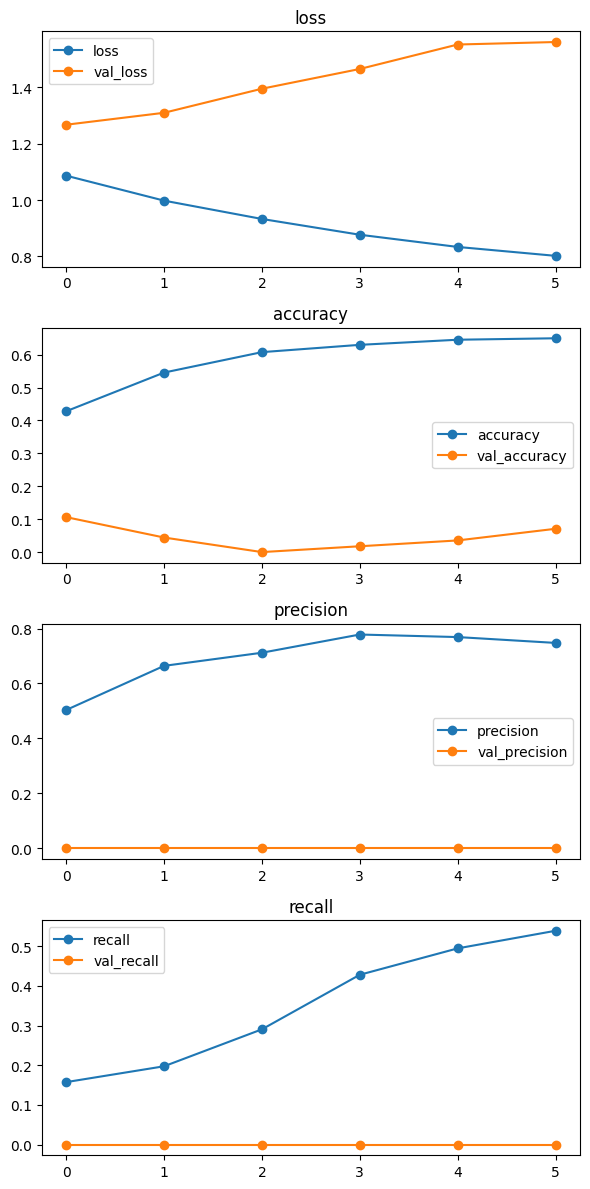

In [ ]:
# plot learning history

plot_history(history);

In [ ]:
# get raw predictions
raw_pred = multi_model.predict(X_test_processed)

# display predictions and binarized true labels
print('Raw Predictions\n', raw_pred[:5])
print('\nbinarized y_test\n', y_test_bin[:5])

2/2 [==============================] - 0s 5ms/step
Raw Predictions
 [[0.87173533 0.03050387 0.09776081]
 [0.14604081 0.79028404 0.06367512]
 [0.17359042 0.6756948  0.15071477]
 [0.26722118 0.5260672  0.2067116 ]
 [0.33888975 0.5080384  0.15307188]]

binarized y_test
 [[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]]


In [ ]:
# convert predictions and labels into integers representing each fish class.
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

print('integer predictions', y_pred)
print('integer true labels', y_true)


integer predictions [0 1 1 1 1 1 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 0 0
 0 1 0 0 1]
integer true labels [0 0 1 1 2 1 0 0 0 1 1 1 0 1 1 0 0 1 2 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0
 1 1 0 1 1]


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.81      0.85      0.83        20
           1       0.76      0.80      0.78        20
           2       0.00      0.00      0.00         2

    accuracy                           0.79        42
   macro avg       0.52      0.55      0.54        42
weighted avg       0.75      0.79      0.77        42



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


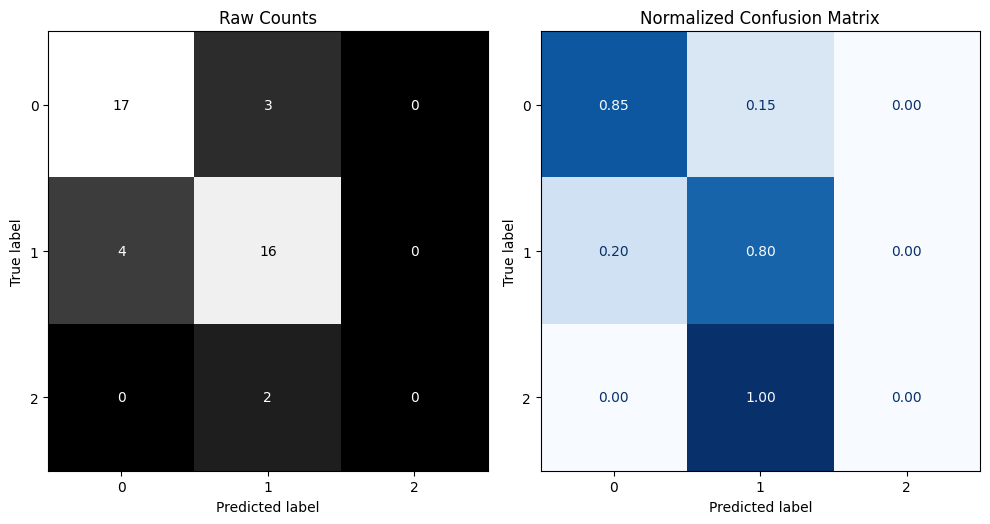

In [ ]:
# Getting Sklearn Metrics
classification_metrics(y_true, y_pred, label='Test Data', figsize=(10,8))



- Tune at least 3 parameters with the Keras tuner:
- Include a dropout layer and adjust the dropout rate.
- Number of Units
- Optimizer
- Learning rates

In [ ]:
!pip install keras-tuner


In [ ]:
from keras_tuner import HyperParameters as hp
import keras_tuner as kt



In [ ]:
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)



In [ ]:
def build_model(hp,):
    # Instantiate Model
    model = Sequential()

    # First hidden layer
    model.add(Dense(units=hp.Int('units1', min_value=10, max_value=50, step=5),
                    input_dim=input_shape,
                    activation='relu'))
    # Dropout layer
    model.add(Dropout(hp.Float(name="dropout_value", min_value=0.0, max_value=0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2])

    # Compile Model
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy', metrics.Precision(), metrics.Recall(), metrics.AUC(name='auc')])

    return model


In [ ]:
# Define tuner object
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=100,
                     directory=folder,
                     overwrite = True,
                     seed = 321,
                     project_name='Rookie_tuning')



In [ ]:
# Run the tuner
epochs =20
tuner.search(X_train_sm, y_train_bin,  epochs=epochs,
             validation_split = .2, callbacks = [early_stopping])



Trial 82 Complete [00h 00m 04s]
val_accuracy: 0.5575221180915833

Best val_accuracy So Far: 0.9469026327133179
Total elapsed time: 00h 04m 20s


In [ ]:
# Obtain best hyperparameter values
best_hps=tuner.get_best_hyperparameters()[0]
best_hps.values



{'units1': 35,
 'dropout_value': 0.1,
 'learning_rate': 0.1,
 'tuner/epochs': 2,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 4,
 'tuner/round': 0}

In [ ]:
# Obtain best model
best_model = tuner.get_best_models()[0]
best_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 35)                1050      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 108       
                                                                 
Total params: 1158 (4.52 KB)
Trainable params: 1158 (4.52 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Fit the model with the early stopping callback
history =best_model.fit(X_train_sm, y_train_bin,
                    validation_split = .2,
                    epochs=50,
                    callbacks = [early_stopping])

Epoch 1/50
15/15 [==============================] - 2s 47ms/step - loss: 0.8287 - accuracy: 0.6741 - precision: 0.6948 - recall: 0.6208 - auc: 0.8398 - val_loss: 0.8658 - val_accuracy: 0.6460 - val_precision: 0.7692 - val_recall: 0.2655 - val_auc: 0.8494
Epoch 2/50
15/15 [==============================] - 0s 12ms/step - loss: 0.6374 - accuracy: 0.7472 - precision: 0.7872 - recall: 0.6563 - auc: 0.8933 - val_loss: 0.5407 - val_accuracy: 0.9204 - val_precision: 0.9412 - val_recall: 0.7080 - val_auc: 0.9745
Epoch 3/50
15/15 [==============================] - 0s 12ms/step - loss: 0.6054 - accuracy: 0.7273 - precision: 0.7835 - recall: 0.6741 - auc: 0.9007 - val_loss: 0.6071 - val_accuracy: 0.8142 - val_precision: 0.8537 - val_recall: 0.6195 - val_auc: 0.9379
Epoch 4/50
15/15 [==============================] - 0s 10ms/step - loss: 0.7396 - accuracy: 0.6940 - precision: 0.7171 - recall: 0.6519 - auc: 0.8710 - val_loss: 0.4930 - val_accuracy: 0.9381 - val_precision: 0.9425 - val_recall: 0.725

(<Figure size 600x1200 with 5 Axes>,
 array([<Axes: title={'center': 'loss'}>,
        <Axes: title={'center': 'accuracy'}>,
        <Axes: title={'center': 'precision'}>,
        <Axes: title={'center': 'recall'}>,
        <Axes: title={'center': 'auc'}>], dtype=object))

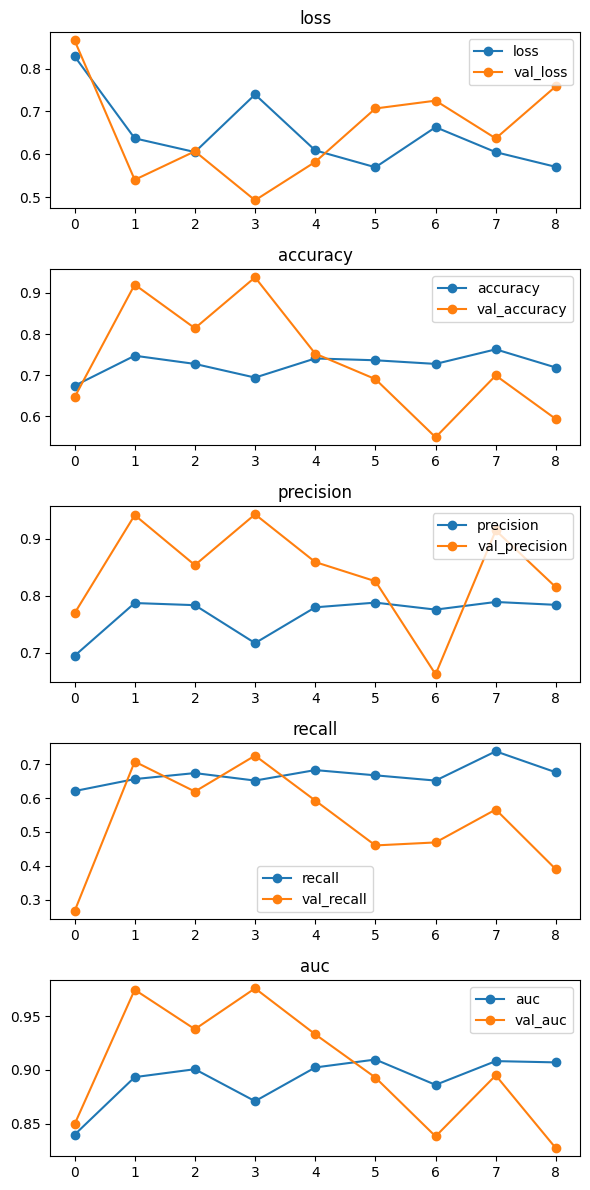

In [ ]:
plot_history(history)

2/2 [==============================] - 0s 5ms/step
Raw Predictions
 [[1.0000000e+00 4.7528458e-13 4.1738220e-24]
 [9.9477673e-01 5.2233110e-03 2.9533654e-19]
 [6.6363192e-03 5.1609898e-01 4.7726467e-01]
 [6.4614192e-02 5.2898192e-01 4.0640390e-01]
 [1.4309350e-03 8.3629680e-01 1.6227230e-01]]

binarized y_test
 [[1 0 0]
 [1 0 0]
 [0 1 0]
 [0 1 0]
 [0 0 1]]
integer predictions [0 0 1 1 1 1 0 0 1 1 1 1 0 1 0 2 0 1 2 1 1 1 0 0 0 0 1 1 1 0 0 0 2 0 1 0 0
 0 2 0 0 2]
integer true labels [0 0 1 1 2 1 0 0 0 1 1 1 0 1 1 0 0 1 2 1 1 1 0 0 1 0 0 1 0 0 0 0 1 0 1 0 0
 1 1 0 1 1]
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.76      0.65      0.70        20
           2       0.20      0.50      0.29         2

    accuracy                    

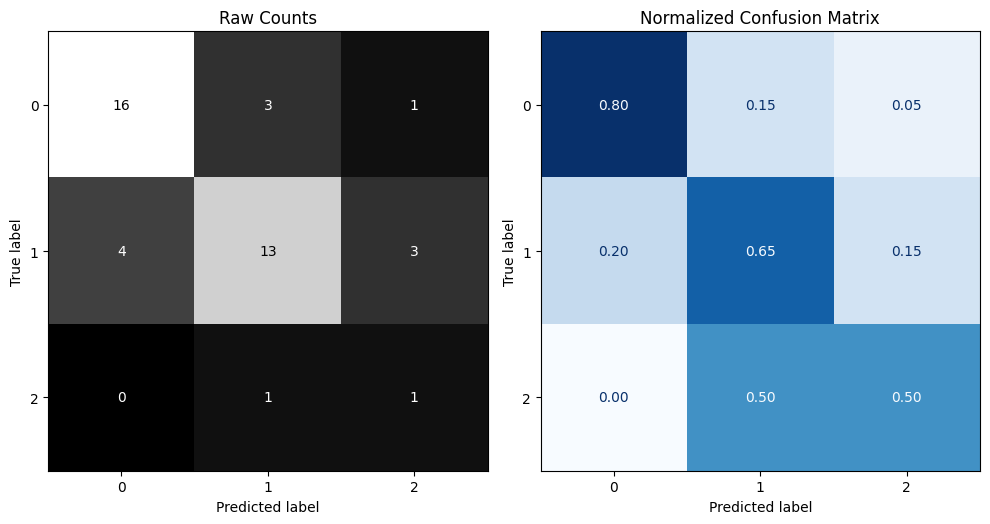

In [ ]:
# get raw predictions
raw_pred = best_model.predict(X_test_processed)

# display predictions and binarized true labels
print('Raw Predictions\n', raw_pred[:5])
print('\nbinarized y_test\n', y_test_bin[:5])

# convert predictions and labels into integers representing each fish class.
y_pred = np.argmax(raw_pred, axis=1)
y_true = np.argmax(y_test_bin, axis=1)

print('integer predictions', y_pred)
print('integer true labels', y_true)


# Getting Sklearn Metrics
classification_metrics(y_true, y_pred, label='Test Data', figsize=(10,8))



In [ ]:
# Evaluate neural network with tuned optimizer, units, and dropout
result = best_model.evaluate(X_test_processed, y_test_bin, return_dict=True)
result



2/2 [==============================] - 0s 18ms/step - loss: 1.1859 - accuracy: 0.7143 - precision: 0.7250 - recall: 0.6905 - auc: 0.8716


{'loss': 1.1859147548675537,
 'accuracy': 0.7142857313156128,
 'precision': 0.7250000238418579,
 'recall': 0.6904761791229248,
 'auc': 0.8715986609458923}